
---
title: "Time series with mixed effects model"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

I've done time-series data with time-to-event models. I'm into mixed effects models. Let's see how we can use correlated data.

References:
- https://www.pymc.io/projects/examples/en/latest/time_series/longitudinal_models.html
- https://bookdown.org/content/4253/a-framework-for-investigating-change-over-time.html#three-important-features-of-a-study-of-change
- https://www.researchgate.net/publication/283557780_Applied_longitudinal_data_analysis_modeling_change_and_event_occurrence_Oxford_University_Press_Oxford


# Custom analysis
- do simple OLS
- repeated measures taking slope (an indicator of progression) from point of draw to CDRg of 1 (not sure about this)
- model trajectory of an individual protein the way you'd do CDR, pool across subjects, use age as time-scale
- how to show trajectory of protein explains trajectory of CDR? think single-cell like velocyto?

# TO DO:
- Have my own visualization theme. Think of colors, colorblind safe, etc. (use "dark")
- Apply black to jupyter lab
    - https://duckduckgo.com/?q=jupyter+lab+black+formater&t=newext&atb=v359-1&ia=web

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [130]:
sns.set_context("talk")
sns.set_palette("colorblind")

In [25]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    Taken from: https://github.com/dustinstansbury/statistical-rethinking-2023/blob/a0f4f2d15a06b33355cf3065597dcb43ef829991/utils.py#L52-L66

    """
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

# Data generation

In [121]:
# Generate a very small synthetic data (assisted by ChatGPT)
n_patients = 10
n_timepoints = 5

# Create patient IDs
patient_ids = np.repeat(np.arange(n_patients), n_timepoints)

# Create time points
time = np.tile(np.arange(n_timepoints), n_patients)

# Create patient-specific attributes (age and treatment)
age = np.random.randint(40, 70, n_patients)
treatment = np.random.binomial(1, 0.5, n_patients)

# Repeat age and treatment to match the longitudinal measurements
age_repeated = np.repeat(age, n_timepoints)
treatment_repeated = np.repeat(treatment, n_timepoints)

# Combine into a DataFrame
df_data = pd.DataFrame(
    {
        "patient_id": patient_ids,
        "time": time,
        "age": age_repeated,
        "treatment": treatment_repeated,
    }
)

df_data.head(10)

,patient_id,time,age,treatment
0,0,0,50,0
1,0,1,50,0
2,0,2,50,0
3,0,3,50,0
4,0,4,50,0
5,1,0,68,0
6,1,1,68,0
7,1,2,68,0
8,1,3,68,0
9,1,4,68,0


Here's the fun part. We'll simulate the outcome variable tumor size, using some mild assumptions and domain knowledge. First, we'll assume that all participants have been identified as having a solid tumor cancer. Therefore:

- Time is also a positive association risk factor.
- Age is likely a risk factor, so create a positive association between age and tumor size. (Note that we'll keep age as a constant for each patient, such that we're looking at a time window of a few months.)
- Whether one has received treatment should decrease the tumor size, so that will be a negative association.

This will be a simple linear model that we'll use to create data:

$$ \mu_i = \alpha + \beta_T T_i + \beta_A A_i + \beta_R R_i  \tag{generative model}$$

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

In [161]:
# Use a generative model to create tumor size with some randomness

alpha_tumor_size = 50  # intercept term
bT = 1  # positive association for time
bA = 0.25  # positive association for age
bR = -5  # negative association for treatment

mu_tumor_size = (
    alpha_tumor_size
    + bT * df_data['time']
    + bA * df_data['age']
    + bR * df_data['treatment']
)

sigma_tumor_size = 2

df_data['tumor_size'] = np.random.normal(mu_tumor_size, sigma_tumor_size)

df_data.head()

,patient_id,time,age,treatment,tumor_size,tumor_size_std
0,0,0,50,0,66.596144,-0.844351
1,0,1,50,0,60.361651,0.823909
2,0,2,50,0,64.371221,-0.196985
3,0,3,50,0,68.276128,0.804609
4,0,4,50,0,63.329732,0.507161


# Data transformation

Before doing any modeling, we'll transform the data since in theory we shouldn't peek. But we can't pick priors unless we have some idea of what the data is like. An easy thing to do is standardize the data and therefore we can use a 0 mean, 2 SD prior to capture most of the data.

In [162]:
df_data['tumor_size_std'] = standardize(df_data['tumor_size'])

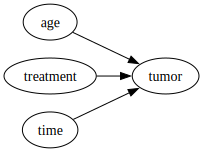

In [163]:
# how to represent patient_specific random effect?
draw_causal_graph(
    edge_list=[("age", "tumor"), ("treatment", "tumor"), ("time", "tumor")],
    graph_direction="LR",
)

In [164]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      50 non-null     int64  
 1   time            50 non-null     int64  
 2   age             50 non-null     int64  
 3   treatment       50 non-null     int64  
 4   tumor_size      50 non-null     float64
 5   tumor_size_std  50 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 2.5 KB


In [165]:
print(f"No. of patients: {df_data['patient_id'].nunique()}")

No. of patients: 10


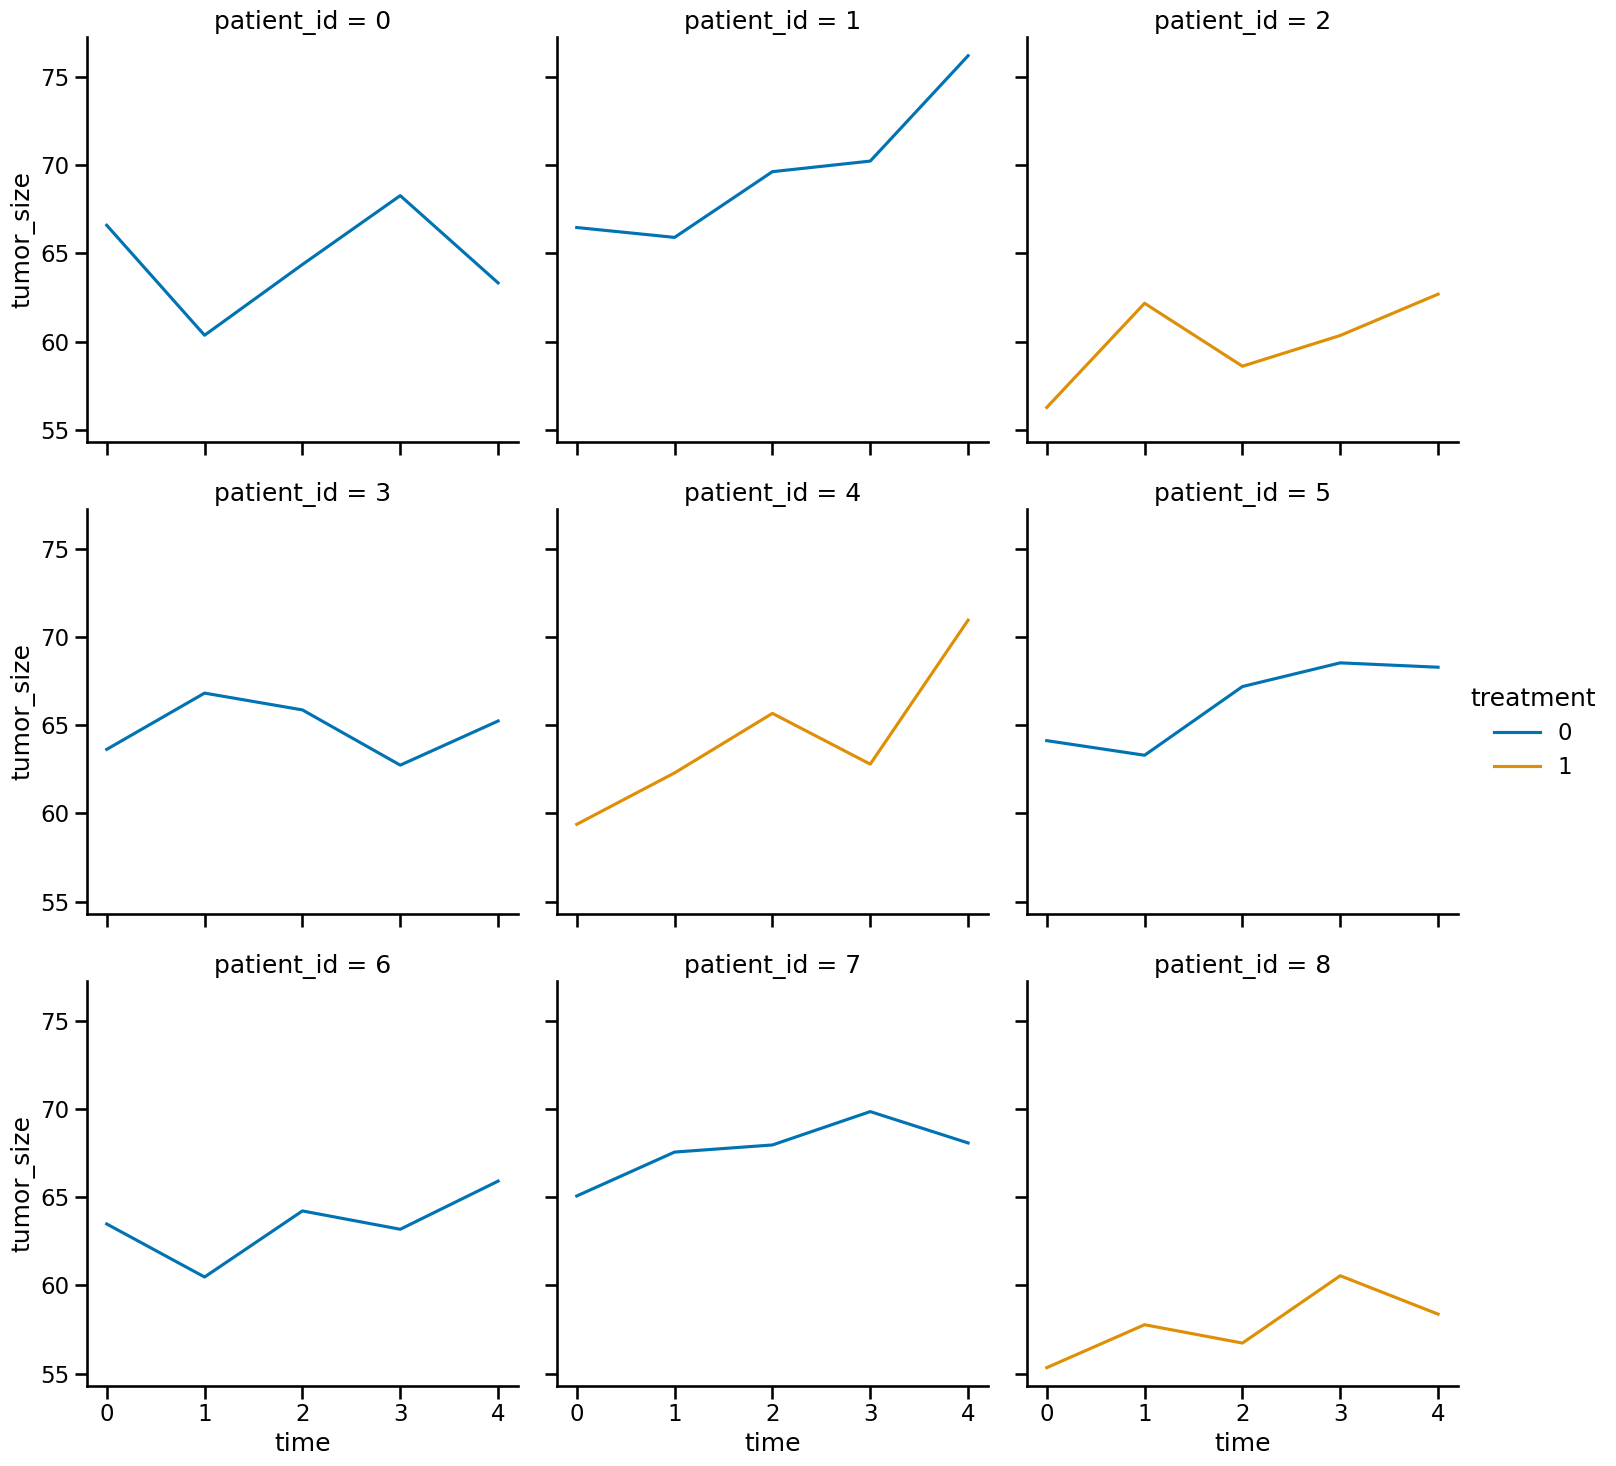

In [166]:
sns.relplot(
    data=df_data.query("patient_id < 9"),
    x="time",
    y="tumor_size",
    col="patient_id",
    col_wrap=3,
    hue='treatment',
    kind="line",
)

<Axes: xlabel='treatment', ylabel='tumor_size'>

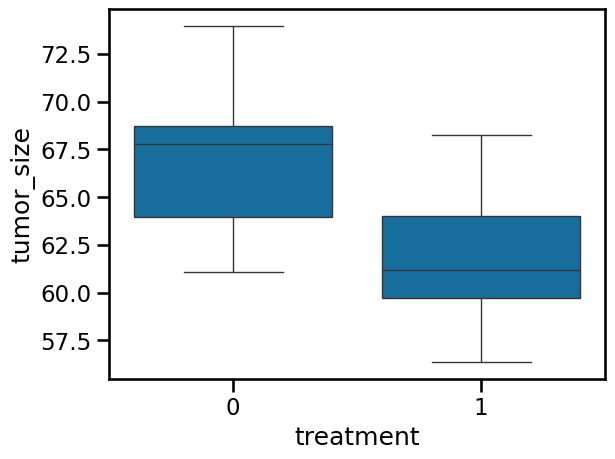

In [156]:
sns.boxplot(
    data=df_data,
    x="treatment",
    y="tumor_size",
)

$$
\begin{split} \begin{aligned} 
    & alcohol \sim Normal(\color{purple}{\mu, \sigma})  \\
    & \color{purple}{\mu} = \color{red}{\alpha} + \color{green}{\beta_{age}} \cdot age + \color{blue}{\beta_{coa}} \cdot coa +  \color{orange}{\beta_{coa*age}}(coa*age) \\
    & \color{red}{\alpha} = \sum_{j=0}^{N} \alpha_{1} + \alpha_{2, j} \ \ \ \ \forall j \in Subjects  \\ 
    & \color{green}{\beta} = \sum_{j=0}^{N} \beta_{1} + \beta_{2, j}  \ \ \ \ \forall j \in Subjects  \\
    & \color{purple}{\sigma} = HalfStudentT(?, ?) \\
    & \alpha_{i, j} \sim Normal(?, ?) \\
    & \beta_{i, j} \sim Normal(?, ?)  \\
    & \color{blue}{\beta_{coa}} \sim Normal(?, ?) \\
    & \color{orange}{\beta_{coa*age}} \sim Normal(?,?)
\end{aligned} \end{split}
$$

# Using statsmodels

In [153]:
# Define the mixed-effects model formula
# https://www.statsmodels.org/dev/_modules/statsmodels/regression/mixed_linear_model.html#MixedLM
# https://www.statsmodels.org/stable/generated/statsmodels.formula.api.mixedlm.html
model = smf.mixedlm(
    "tumor_size_std ~ time + age + treatment",
    df_data,
    groups=df_data["patient_id"],
    re_formula="~time",   #  A one-sided formula defining the variance structure of the model.  The default gives a random intercept for each group.
    #re_formula="~patient_id",
)

# Fit the model
result = model.fit()

# Print the summary of the model
result.summary()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 50      Method:             REML          
No. Groups:       10      Scale:              0.2752        
Min. group size:  5       Log-Likelihood:     -48.0325      
Max. group size:  5       Converged:          No            
Mean group size:  5.0                                       
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -3.485    0.662 -5.266 0.000 -4.782 -2.188
time               0.262    0.064  4.097 0.000  0.137  0.388
age                0.060    0.011  5.438 0.000  0.038  0.082
treatment         -1.192    0.201 -5.928 0.000 -1.586 -0.798
Group Var          0.159    0.480                           
Group x time Cov  -0.046    0.177                           
time Var           0.013    0.076                           
============================================================

"""

## Varying intercept model

In [154]:
# Define the mixed-effects model formula with only varying intercepts
model = smf.mixedlm("tumor_size_std ~ 1", df_data, groups=df_data["patient_id"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 50      Method:             REML          
No. Groups:       10      Scale:              0.4878        
Min. group size:  5       Log-Likelihood:     -62.6166      
Max. group size:  5       Converged:          Yes           
Mean group size:  5.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.000     0.260  -0.000  1.000  -0.510   0.510
Group Var      0.580     0.506                               



# Using pymc

Let's define the equation. We're going to assume the tumor size is Gaussian distributed.

It will be a linear combination of independent variables for time, age, and treatment. How will we represent the `patient_id`? 

There will be a term for average tumor size and the patient-specific tumor size will be the "random effect".

s = tumor size
t = time
a = age
r = treatment

After reading McElreath, for now, I will ignore time, age, and treatment and just think of patient as a cluster.

$$ \mu_i = \alpha_{\text{pt[i]}} + \beta_T T_i + \beta_A A_i + \beta_R R_i  \tag{save for later}$$
$$ \beta_T, \beta_A, \beta_R \sim \text{Normal}(0, 1) \tag{save for later} $$


Let's do this step-by-step and work our way from the most naive, simplest models to more complex and informative.

1. **Complete pooling, intercepts only.** Ignore patients as clusters.
2. **No pooling, intercepts only**. Keep intercepts separate for each patient. Ignore information across patients.
3. **Partial pooling, intercepts only.** Share information across patients.

# Model 1. Complete pooling.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha  $$

$$ \alpha \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

The `patient_id` variable is completely ignored. A subscript to denote the patient is not relevant here?

In [27]:
# complete pooling, intercepts only
with pm.Model() as m1:

    # priors
    a = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)
    
    # linear model
    mu = a
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:51

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


In [28]:
az.summary(trace_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.001,0.044,-0.085,0.081,0.001,0.001,4108.0,2843.0,1.0
sigma,1.002,0.033,0.941,1.064,0.001,0.000,4231.0,2744.0,1.0


In [29]:
standardize(df_data["tumor_size"]).describe()

count    5.000000e+02
mean     2.183143e-15
std      1.001002e+00
min     -2.332656e+00
25%     -7.146172e-01
50%     -6.385169e-04
75%      6.553856e-01
max      2.740292e+00
Name: tumor_size, dtype: float64

<Axes: >

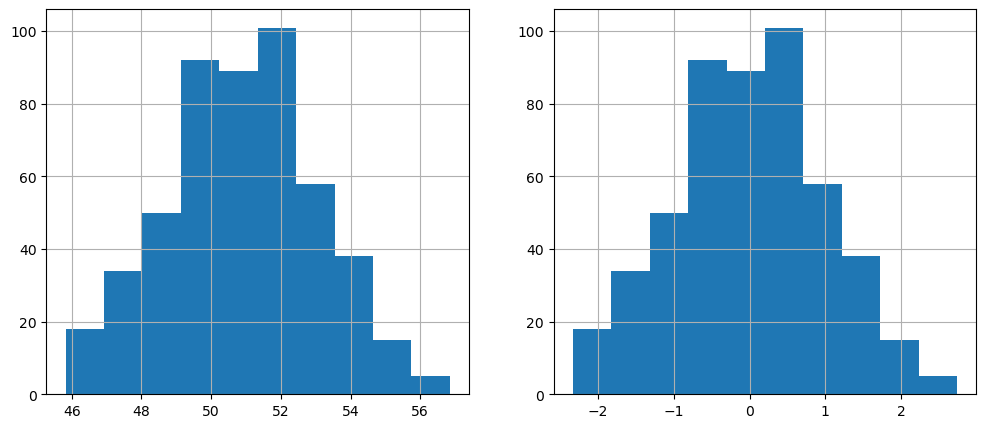

In [31]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))   # do add subplots
df_data["tumor_size"].hist(ax=ax0)
df_data["tumor_size_std"].hist(ax=ax1)

# Model 2. No pooling.
Acknowledge that there are patient clusters but do not share any information across them. In other words have a prior but no adaptive regularization.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

In [42]:
df_data.head()

,patient_id,time,tumor_size,age,treatment,tumor_size_std
0,0,0,50.514378,44,0,-0.100848
1,0,1,49.589689,44,0,-0.499350
2,0,2,50.859369,44,0,0.047828
3,0,3,53.404866,44,0,1.144829
4,0,4,51.531560,44,0,0.337514


In [45]:
df_data['patient_id'].nunique()

20

In [49]:
# no pooling, intercepts only
with pm.Model() as m2:

    # priors
    a = pm.Normal("a", 0.0, 1, shape=df_data['patient_id'].nunique())
    sigma = pm.Exponential("sigma", 1.0)
    
    # linear model... # initialize with pymc data?... represent patient as its own cluster
    mu = a[df_data['patient_id']]
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m2 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:29

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


In [50]:
az.summary(trace_m2).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.156,0.408,-0.627,0.889,0.004,0.007,9283.0,2878.0,1.0
a[1],-0.271,0.405,-1.037,0.482,0.004,0.005,9487.0,2949.0,1.0
a[2],0.103,0.406,-0.629,0.909,0.004,0.007,8760.0,3246.0,1.0
a[3],0.517,0.402,-0.293,1.219,0.004,0.005,8122.0,2893.0,1.0
a[4],0.585,0.415,-0.187,1.380,0.004,0.004,9844.0,2757.0,1.0


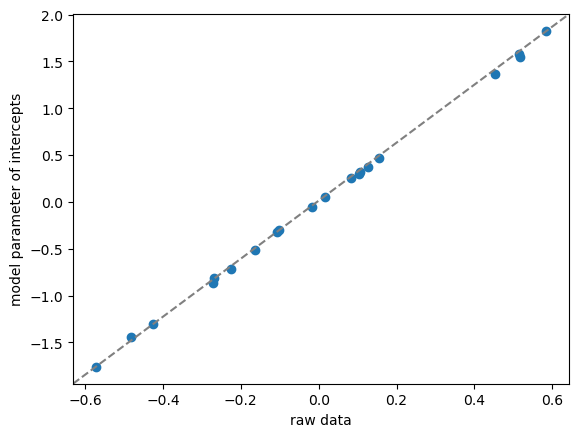

In [56]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_m2, var_names=['a'])['mean'],
    standardize(df_data.groupby('patient_id')['tumor_size'].mean())
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='gray')
ax.set(
    xlabel='raw data',
    ylabel='model parameter of intercepts'
);

# Model 3. Use random intercepts.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\text{pt}}) $$

$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$



$$ \sigma_{\text{pt}} \sim \text{Exponential}(1) $$

$$ \sigma \sim \text{Exponential}(1) $$


make alpha_i use alpha_bar as a regularizing prior... unsure how to think of SD priors... can sigma parameter be partially pooled?

In [57]:
# multilevel model, random intercepts
with pm.Model() as m3:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)
    
    # prior for SD of patients
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data['patient_id']]
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m3 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 1,360 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺  98% 0:00:01 / 0:00:41

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [61]:
az.summary(trace_m3, var_names=['a']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.052,0.168,-0.286,0.343,0.033,0.024,27.0,233.0,1.11
a[1],0.001,0.172,-0.354,0.262,0.043,0.031,18.0,214.0,1.16
a[2],0.043,0.177,-0.329,0.303,0.038,0.027,23.0,219.0,1.13
a[3],0.083,0.178,-0.246,0.399,0.034,0.024,25.0,229.0,1.16
a[4],0.089,0.175,-0.227,0.444,0.018,0.012,71.0,680.0,1.56


In [85]:
az.summary(trace_m3, var_names=['a_bar', 'sigma']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.035,0.122,-0.167,0.204,0.040,0.029,11.0,213.0,1.30
sigma,1.001,0.062,0.884,1.133,0.007,0.005,75.0,228.0,1.55


# Comparison of estimates of complete pooling, no pooling, partial pooling

- do means and SD

While there isn't an appreciable difference, the multilevel model has a lower standard deviation for each cluster. This is the partial pooling effect.

# Varying effects: models with slopes

## Model 4. No pooling, with slope for treatment.

In [167]:
df_data.head()

,patient_id,time,age,treatment,tumor_size,tumor_size_std
0,0,0,50,0,66.596144,0.602119
1,0,1,50,0,60.361651,-0.917804
2,0,2,50,0,64.371221,0.059699
3,0,3,50,0,68.276128,1.011686
4,0,4,50,0,63.329732,-0.194208


In [168]:
df_data.groupby(['treatment'])['tumor_size_std'].mean()

treatment
0    0.480397
1   -0.720595
Name: tumor_size_std, dtype: float64

In [169]:
# no pooling model
with pm.Model() as m4:

    # prior for sigma
    sigma = pm.Exponential("sigma", 1.0)
    
    # alpha, beta priors for each patient, set to numerical value and not pool
    a = pm.Normal("a", 0, 2, shape=len(df_data["patient_id"].unique()))
    bR = pm.Normal("bR", 0, 2, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data['patient_id']] + bR[df_data['patient_id']]
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m4 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:44

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


In [170]:
az.summary(trace_m4, var_names=['bR']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bR[0],0.082,1.423,-2.481,2.883,0.024,0.023,3433.0,2599.0,1.0
bR[1],0.631,1.464,-2.205,3.243,0.025,0.023,3333.0,2685.0,1.0
bR[2],-0.516,1.419,-3.205,2.052,0.024,0.022,3662.0,2647.0,1.0
bR[3],0.096,1.424,-2.606,2.710,0.024,0.024,3404.0,2409.0,1.0
bR[4],-0.003,1.400,-2.552,2.725,0.022,0.022,3993.0,2919.0,1.0


## Model 5. Multilevel model, with slope for treatment.

In [171]:
# multilevel model
with pm.Model() as m5:

    # hyperparameters, priors for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    bR_bar = pm.Normal("bR_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)
    
    # prior for SD of patients
    sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
    sigma_bR = pm.Exponential("sigma_bR", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_alpha, shape=len(df_data["patient_id"].unique()))

    # priors for beta for each patient
    bR = pm.Normal("bR", bR_bar, sigma_bR, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data['patient_id']] + bR[df_data['patient_id']]
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m5 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 500 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:47

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [172]:
az.summary(trace_m5, var_names=['a_bar', 'bR_bar', 'sigma']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.180,0.751,-1.267,1.353,0.108,0.077,54.0,555.0,1.07
bR_bar,-0.168,0.728,-1.274,1.297,0.087,0.062,85.0,551.0,1.05
sigma,0.679,0.074,0.538,0.814,0.002,0.002,1121.0,1604.0,1.02


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

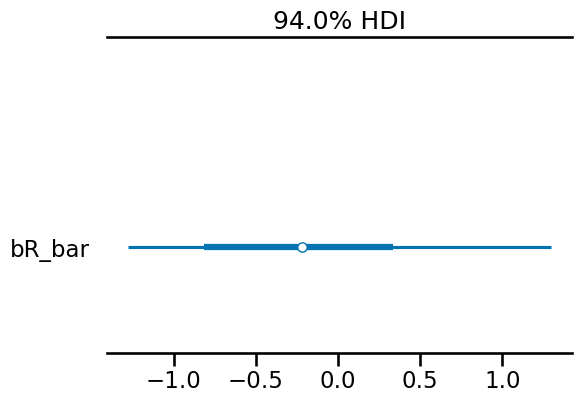

In [180]:
az.plot_forest(trace_m5, var_names='bR_bar', combined=True)

In [173]:
az.summary(trace_m5, var_names=['bR']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bR[0],-0.126,0.817,-1.471,1.481,0.093,0.066,93.0,890.0,1.05
bR[1],0.378,0.971,-1.282,2.060,0.184,0.132,32.0,246.0,1.09
bR[2],-0.567,0.830,-2.142,1.007,0.043,0.030,372.0,750.0,1.04
bR[3],-0.090,0.833,-1.381,1.522,0.104,0.074,72.0,986.0,1.06
bR[4],-0.168,0.815,-1.578,1.401,0.092,0.065,93.0,726.0,1.05


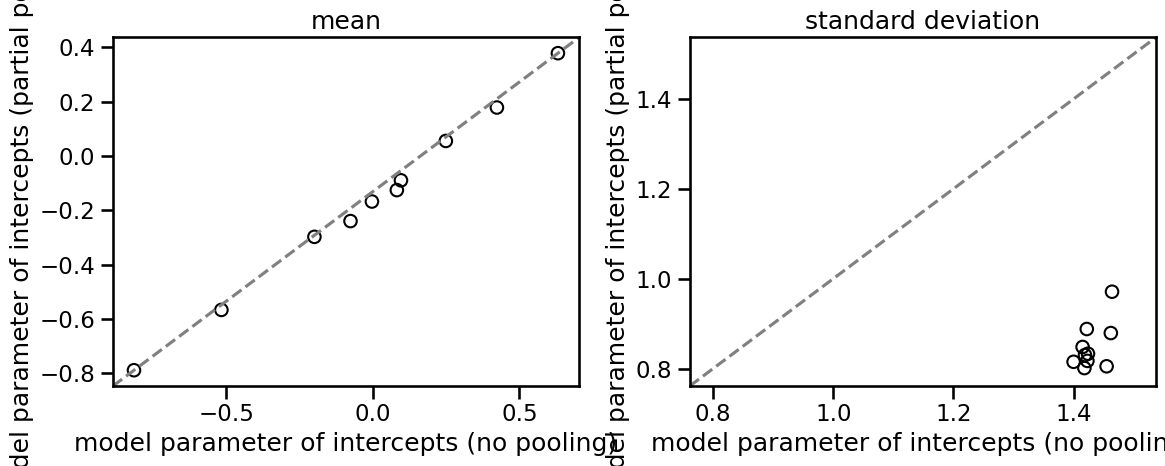

In [177]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# means
ax0.scatter(
    az.summary(trace_m4, var_names=['bR'])['mean'],
    az.summary(trace_m5, var_names=['bR'])['mean'],
    facecolors='none',
    edgecolors='k'
)
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle='dashed', color='gray')
ax0.set(
    xlabel='model parameter of intercepts (no pooling)',
    ylabel='model parameter of intercepts (partial pooling)',
    title='mean'
);

# SD
ax1.scatter(
    az.summary(trace_m4, var_names=['bR'])['sd'],
    az.summary(trace_m5, var_names=['bR'])['sd'],
    facecolors='none',
    edgecolors='k'
)
ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle='dashed', color='gray')
ax1.set(
    xlabel='model parameter of intercepts (no pooling)',
    ylabel='model parameter of intercepts (partial pooling)',
    title='standard deviation'
);
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle='dashed', color='gray')

# Calculate the minimum and maximum of both x and y data
data_min = min(min(az.summary(trace_m4, var_names=['bR'])['sd']), min(az.summary(trace_m5, var_names=['bR'])['sd']))
data_max = max(max(az.summary(trace_m4, var_names=['bR'])['sd']), max(az.summary(trace_m5, var_names=['bR'])['sd']))

# Set the limits to be the same for both axes
ax1.set_xlim(data_min*0.95, data_max*1.05)
ax1.set_ylim(data_min*0.95, data_max*1.05)

f.tight_layout()

# MODEL WITH SLOPES

In [10]:
# multilevel model
with pm.Model() as m3:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)
    
    # prior for SD of patients
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))

    # priors for betas
    bT = pm.Normal("bT", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bR = pm.Normal("bR", 0, 1)

    # linear model
    mu = a[df_data['patient_id']
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_mme = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, sigma_pt, a, bT, bA, bR]


/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
az.summary(trace_mme, var_names=['a_bar', 'bT', 'bA', 'bR'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,2.127,0.934,0.470,3.933,0.069,0.049,180.0,488.0,1.02
bT,0.544,0.063,0.433,0.666,0.001,0.001,3216.0,2668.0,1.00
bA,0.851,0.021,0.815,0.891,0.002,0.001,118.0,278.0,1.02
bR,0.275,0.813,-1.199,1.869,0.042,0.029,382.0,687.0,1.00


In [16]:
az.summary(trace_mme, var_names=['a']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],4.424,1.398,1.905,6.948,0.102,0.073,187.0,569.0,1.01
a[1],-9.324,1.652,-12.376,-6.324,0.128,0.091,167.0,411.0,1.01
a[2],-3.166,1.567,-5.975,-0.116,0.121,0.085,169.0,462.0,1.02
a[3],-6.716,1.604,-9.723,-3.710,0.127,0.090,160.0,423.0,1.02
a[4],-9.756,1.686,-12.962,-6.729,0.132,0.093,163.0,443.0,1.02


In [15]:
df_data.groupby('patient_id')['tumor_size'].mean().head()

patient_id
0    51.488039
1    49.438208
2    51.443730
3    50.355497
4    49.872089
Name: tumor_size, dtype: float64

In [17]:
df_data.groupby('patient_id')['tumor_size'].head(1).head()

0     52.521422
5     48.838559
10    54.273947
15    50.312740
20    46.751843
Name: tumor_size, dtype: float64

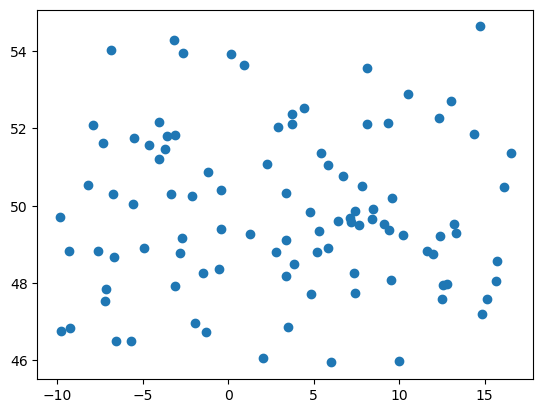

In [18]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_mme, var_names=['a'])['mean'],
    df_data.groupby('patient_id')['tumor_size'].head(1)
)
    

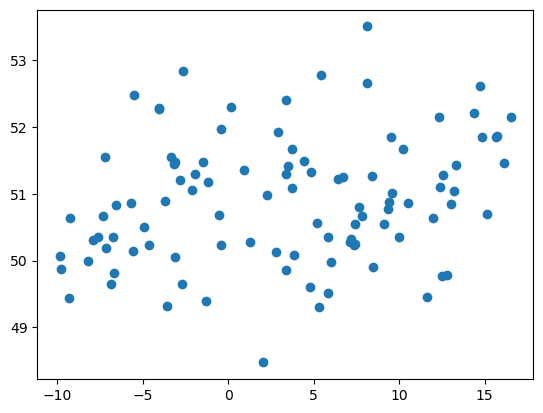

In [19]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_mme, var_names=['a'])['mean'],
    df_data.groupby('patient_id')['tumor_size'].mean()
)

# OLD BELOW

# Introduction of cause and effect
- Causal inference matters because it helps distinguish variables that are associations from those that can be causal. It's very common to misunderstand data causality unfortunately.
- Experiments are the gold standard because it can be used to control confounding. But experiments can be unethical or impractical in many cases. For example, researchers can't simply force smoking on groups of people. Establishing a link between smoking and lung cancer was done with survey data.- Survey data is often self-reported so it's ripe with biases. American Community Survey is one example of survey data. When using survey data, it's recommended to:
    - use probability sampling when possible
    - correct biases with weights
    - apply techniques for missing data
    - ensure survey's topical relevance
    - invest time in understanding survey data complexity

# Observables vs. unobservable causes
- Variables can be observed in the data but some variables are unboserved, due to lack of measurement or the ability to measure. Personal motivation is something hard to measure for example. But unobserved variables can bias results so they're crucial in causal inference.
- Endogeneity: occurs when an explanatory variable is correlated with the error term in a model. It can happen when a variable is left out of a regression model. Thinking about unobserved variables can guide researchers to using better causal techniques.
- DAGs help one can better understand causal flow of models. We have to be careful about the presence of backdoor paths between the predictor of interest and the outcome variable.


- Not controlling for the backdoor path will lead to bias between X1 and Y
- X2 often called a confounder

In [9]:
# create a dataframe that holds the number and probability for each group
n_obs = 200
x2 = stats.norm.rvs(loc=0, scale=1, size=200)
x1 = stats.norm.rvs(loc=0, scale=1, size=200) + x2
y = x1 + x2

model0 = sm.OLS(y, x1)
model1 = sm.OLS(y, x1 + x2)

results0 = model0.fit()
results1 = model1.fit()

In [19]:
# with x1 only gives a biased estimate
results0.params

array([1.46420051])

In [23]:
# including x2 recovers the right parameter given the data generating process
results1.params

array([1.])

But what if x2 is unobserved? Unfortunately the backdoor path cannot be closed. This is where basic regression analysis fails us. But this is where more advanced methods can help us in the case of unobserved confounds.

<p style="text-align: center;font-weight:bold;">DAGs and Methods</p>

| Methodology | Controls for Unobserved Confounds | 
| ----- | ------- |
| Regression analysis | No (controls for observed confounds only) | 
| Propensity score matching | No (controls for observed confounds only) | 
| Instrumental variables | Yes (if a valid instrument is used) | 
| Regression discontinuity designs | Partially (near the cutoff point) |
| Regression with time effects  | Partially (for time-varying confounders) |
| Fixed effects regression  | Yes (for time-invariant confounders within entities) |
| Difference-in-Differences Models | Yes (if trends are parallel without  treatment) |
| Synthetic control methods | Partially (for observed and unobserved pre-treatment confounders) |


# What are treatment effects?

- The causal literature has acronyms like ATE, ATT, LATE, CATE, etc.
- They're called potential outcome notation
- It can define the methodological approach and narrative of results
- Essentially this is defining counterfactuals (parallel universes): a comparison between two states of the world.
    - For example, imagine someone takes a pill and the outcome is measured. In a parallel world, they don't take it and the outcome is measured. The difference in outcomes is the treatment effect (the causal effect of the pill).
- Of course, we can't have both states. But we can have different states of causality. This results in different kinds of treatment effects.

**Average Treatment Effect (ATE)**

The average effect of the treatment across the entire population.
$$ATE = E[Y^1_i - Y^0_i]$$
where $Y^1$ is the outcome when treatment is given, $Y^0$ is the outcome when treatment is not given, $i$ is for individual, and $E$ is the expected, which means the effect is averaged out over all individuals.

*Interpretation*: If you impose a treatment on everyone, then this is the change the average individual will see. But it literally means everyone and so if a drug is sex-specific, using the ATE wouldn't make sense.

**Average Treatment Effect on the Treated (ATT)**

The average effect of the treatment for those treated.
$$ ATT = E[Y^1_i - Y^0_i | \text{Treated}=1 ] $$

*Interpretation*: Shows effect of intervention only on those that received the intervention (treatment). ATT is usually different from ATE due to selection. (Unsure about $Y^0$ since by definition it shouldn't exist here?)

Non-random treatment will likely lead to ATT and not ATE since people often self-select expecting benefits.

**Average Treatment Effect on the Untreated (ATU)**

The average effect of the treatment for those in the control group.
$$ ATU = E[Y^1_i - Y^0_i | \text{Treated}=0 ] $$

But this can't be estimated. It's still useful to think about what would have happened to those who were not reached by an intervention.

**Local Average Treatment Effect (LATE)**

The average effect of the treatment for those who complied
$$ LATE = E[Y^1_i - Y^0_i | \text{Compliers}=1 ] $$
Treatment conditions only received under certain conditons; conditions influenced by another "instrumental variable".
Example: Study the impact of receiving a scholarship. The instrumental variable might be living in a particular region, LATE would measure the effect of the scholarship on just those students who received it due to their location. Many compliers means LATE approaches ATE. But few compliers limits external validity.

Conclusion
- Understanding true effects in non-randomized settings (experiments approach ATE and ATT).
- Advanced methods lead to different effects
- Model selection matters!

# An applied example: The Lalonde debate

How different are nonexperimental methods compared to experimental methods? Focus of seminal study from Robert Lalonde in 1986.

- National supported work program was temporary job training program in the mid-1970s.
- It was designed to help people with temporary work experience.
- But there was a randomized component! 50/50 chance of getting help or no help.

Lalonde compared the randomzied experiment data with CPS and PSID surveys. The experimental data recovered the ATE. When looking at experimental data, there was a net positive in income suggesting the program worked. He got similar values using causal inference methods. However, survey data varied wildly. Depending on which one you choose can lead to very different policies.

Conclusion
- A wake-up call for economists!
- Methods matter, and careful design must be given to causal studies.
- This led to significant advances in methods and how to use surveys.



In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu May 09 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

seaborn    : 0.13.2
statsmodels: 0.14.1
scipy      : 1.12.0
matplotlib : 3.8.2
pandas     : 2.2.0
numpy      : 1.25.2

Watermark: 2.4.3

